<img src="https://gitlab.inf.unibz.it/earth_observation_public/eurac-openeo-examples/-/raw/main/python/aux_data/eurac_EO.png"
     alt="EURAC EO logo"
     style="float: left; margin-right: 10px; max-width: 300px" />

<img src="https://avatars.githubusercontent.com/u/63704085?s=400&u=5dc6c45b7d457ce6f303fbc612091cb2c133482f&v=4"
     alt="SAR2Cube logo"
     style="float: right; max-width: 200px" />
# SAR2Cube and openEO - Accessing and Analyzing SAR data on-the-fly
Author michele.claus@eurac.edu

Date: 2022/09/29

Updated: 2023/05/15

## Useful links:

SAR2Cube website: https://sar2cube.projects.eurac.edu/

openEO main website: https://openeo.org/

openEO Python Client documentation: https://open-eo.github.io/openeo-python-client/index.html

Getting started guide for openEO with python: https://openeo.org/documentation/1.0/python/

## Topics
- Login to Eurac's openEO backend containing the SAR2Cube data sets
- Discover the data sets and processes
- Access and process data via openEO
- Compute the intensity over the area of interest with different Multi Look sizes in SAR and geocoded domain

## Import all the libraries and utilities functions
The ones included in the eo_utils.py file are needed for the ipyleaflet interactive map

Please check to have the latest `openeo` library. Please check here for the latest available version: https://pypi.org/project/openeo/

In [ ]:
import os
import openeo
import xarray as xr
import matplotlib.pyplot as plt
try:
    from eo_utils import *
except Exception as e:
    print(e)

## Connect and login

In [ ]:
openeoHost = "https://openeo.eurac.edu"
conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")

### Get the info of the account

In [ ]:
conn.describe_account()

## openEO back-end discovery

### Discover the available collections

In [ ]:
conn.list_collections()

### Discover the available processes

In [ ]:
conn.list_processes()

# SAR processing

We load an openEO collection containing pre-processed Sentinel-1 SLC data. It contains real and imaginary parts of each polarization, the longitude and latitude grids used for geocoding, LIA and DEM used for radar masking.

In [ ]:
conn.describe_collection("SAR2Cube_SInCohMap_S1_L0_117_ASC_SOUTH_TYROL")

## Select the AOI
Use the rectangle selection tool to select the area of interest.

If it does not work, it means that some library is missing and the functions contained in `eo_utils.py` could not be loaded.

Uncomment the line defining `spatial_extent` to use a predefined area instead.

In [ ]:
center = [46.5, 11.4]
zoom = 12

eoMap = openeoMap(center,zoom)
eoMap.map

In [ ]:
bbox = eoMap.getBbox()
print("Coordinates selected from map:","\n west",bbox[0],"\n east",bbox[2],"\n south",bbox[1],"\n north",bbox[3])

## Load the datacube

In [ ]:
conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")

collection      = "SAR2Cube_SInCohMap_S1_L0_117_ASC_SOUTH_TYROL"
temporal_extent = ["2022-06-01T00:00:00.000Z", "2022-06-30T00:00:00.000Z"]
# spatial_extent  = {"west":bbox[0],"east":bbox[2],"south":bbox[1],"north":bbox[3]}
spatial_extent = {"west": 11.259613, "east": 11.406212, "south": 46.461019, "north": 46.522237}

S1_slant_range = conn.load_collection(collection,spatial_extent=spatial_extent,temporal_extent=temporal_extent)

## Compute the VH intensity
We compute the intensity from the complex data

In [ ]:
i_VH = S1_slant_range.band("i_VH")
q_VH = S1_slant_range.band("q_VH")
S1_INT = i_VH**2+q_VH**2
S1_INT_VH = S1_INT.add_dimension(name="bands",label="VH")

## Compute the Multi-Look
The size of the multi-look window can be changed depending on the requirements. Have a look at the following image explaining Multi-Look.

[source: ESA](https://step.esa.int/docs/tutorials/S1TBX%20SAR%20Basics%20Tutorial.pdf)
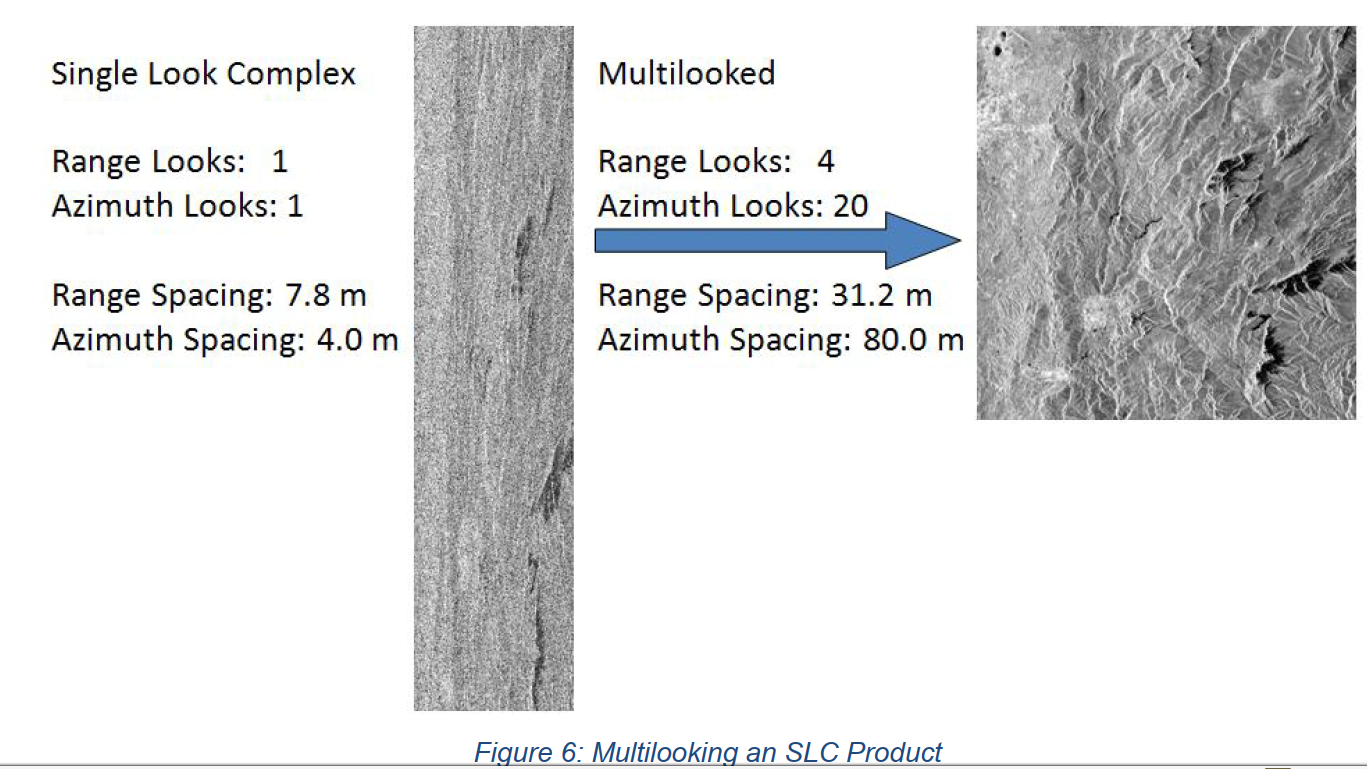

In [ ]:
range_looks   = 4
azimuth_looks = 19

S1_INT_ML = S1_INT_VH.aggregate_spatial_window(
    size=[azimuth_looks,range_looks],
    reducer="mean")

## Temporal average
We reduce the temporal dimension to get a 2d image for visualization purposes. This can also be considered as a multi-look along time.

In [ ]:
S1_INT_ML_VH_MEAN = S1_INT_ML.reduce_dimension(reducer="mean", dimension="DATE")

Rescale the result for storing it into a PNG image

In [ ]:
S1_INT_ML_VH_MEAN_0_255 = S1_INT_ML_VH_MEAN.linear_scale_range(input_min=0, input_max=0.1, output_min=0, output_max=255)

## Download the result

In [ ]:
%%time
S1_INT_PNG = S1_INT_ML_VH_MEAN_0_255.save_result(format="PNG")
S1_INT_PNG.download("./S1_INT_VH_19X4_ASC_ST.png")

Do the same without multi-look to show a comparison

In [ ]:
%%time
S1_INT_VH_MEAN = S1_INT_VH.reduce_dimension(reducer="mean", dimension="DATE")
S1_INT_VH_MEAN_0_255 = S1_INT_VH_MEAN.linear_scale_range(input_min=0, input_max=0.1, output_min=0, output_max=255)
S1_INT_PNG_2 = S1_INT_VH_MEAN_0_255.save_result(format="PNG")
S1_INT_PNG_2.download("./S1_INT_VH_ASC_ST_SINGLE_LOOK.png")

## Comparison of original SLC data vs multi-looked version
Average intensity in June 2022

In [ ]:
plot_args = {"cmap":"Greys_r","vmin":0,"vmax":0.1}
fig, ax = plt.subplots(1,2,figsize=(20,10))
im = plt.imread("./S1_INT_VH_ASC_ST_SINGLE_LOOK.png")
ax[0].set_title("VH Sigma0 intensity - Single Look")
ax[0].imshow(im,**plot_args)
plot_args = {"cmap":"Greys_r","vmin":0,"vmax":1}
im = plt.imread("./S1_INT_VH_19X4_ASC_ST.png")
ax[1].set_title("VH Sigma0 intensity - Multi Look 19x4")
ax[1].imshow(im,**plot_args)
plt.plot()

# From slant-range to geographic (UTM) coordinates: geocoding

Load the datacube in the same way as before.

In [ ]:
conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")

collection      = "SAR2Cube_SInCohMap_S1_L0_117_ASC_SOUTH_TYROL"
temporal_extent = ["2022-06-01T00:00:00.000Z", "2022-06-30T00:00:00.000Z"]
# spatial_extent  = {"west":bbox[0],"east":bbox[2],"south":bbox[1],"north":bbox[3]}
spatial_extent = {"west": 11.259613, "east": 11.406212, "south": 46.461019, "north": 46.522237}

S1_slant_range = conn.load_collection(collection,spatial_extent=spatial_extent,temporal_extent=temporal_extent)

Compute the intensity, this time we use the VV polarization.

In [ ]:
i_VV = S1_slant_range.band("i_VV")
q_VV = S1_slant_range.band("q_VV")
S1_INT = i_VV**2+q_VV**2
S1_INT_VV = S1_INT.add_dimension(name="bands",label="VV")

Compute the Multi Look over the intensity.

In [ ]:
range_looks   = 4
azimuth_looks = 19

S1_INT_VV_ML = S1_INT_VV.aggregate_spatial_window(
    size=[azimuth_looks,range_looks],
    reducer="mean")

Linear to dB conversion:

In [ ]:
from openeo.processes import log
S1_INT_VV_ML = S1_INT_VV_ML.apply(lambda x: 10*log(x,base=10))

Compute the same Multi Look over the coordinate grids for geocoding

In [ ]:
lat_lon_grids = S1_slant_range.filter_bands(["grid_lon","grid_lat"])

lat_lon_grids_ML = lat_lon_grids.aggregate_spatial_window(
    size=[azimuth_looks,range_looks],
    reducer="mean")

Merge the intensity and the coordinate grids into the same datacube

In [ ]:
S1_INT_VV_ML = S1_INT_VV_ML.merge_cubes(lat_lon_grids_ML)

Compute the average over time

In [ ]:
S1_INT_ML_VV_MEAN = S1_INT_VV_ML.reduce_dimension(reducer="mean", dimension="DATE")

Apply geocoding. We choose 20m resolution for the pixel size and the local UTM zone as projection.

We can choose only from 10, 20 or 60m for resolution, for being able to align the data with Sentinel-2 grid.

This process is not yet an official openEO process and therefore the syntax to apply it is not streamlined as with the other processes.

In [ ]:
args_geocoding = {"resolution":20,"crs":32632}
S1_INT_ML_VV_GEOCODED = S1_INT_ML_VV_MEAN.process("geocode",args_geocoding, data=S1_INT_ML_VV_MEAN)

Download the result as a geoTiff to check the geocoding

In [ ]:
%%time
S1_INT_ML_VV_GEOCODED.download("./S1_INT_VV_4x19_GEOCODED_ASC_DB_ST_20m.tiff",format="GTiff")

Loading the geoTiff using rioxarray

In [ ]:
vv_asc_geocoded = rioxarray.open_rasterio("./S1_INT_VV_4x19_GEOCODED_ASC_DB_ST_20m.tiff")
vv_asc_geocoded

Visualize the result with matplotlib

In [ ]:
plot_args = {"cmap":"Greys_r","add_colorbar":False,"vmin":-30,"vmax":0}
fig, ax = plt.subplots(1,1)
vv_asc_geocoded[0].plot.imshow(ax=ax,**plot_args)
ax.set_title("VV Sigma0 Intensity - ML 19x4 - [dB] - Ascending")
plt.show()

Visualize the result interactively on the map. Note: this might not work depending on your Python environment.

If it does not work, it means that some library is missing and the functions contained in `eo_utils.py` could not be loaded.

In [ ]:
center = [46.5, 11.4]
zoom = 13

eoMap = openeoMap(center,zoom)
addLayer(eoMap,"./S1_INT_VV_4x19_GEOCODED_ASC_DB_ST_20m.tiff","VV_ASC_20m",clip=[-30,0])
eoMap.map